<a href="https://colab.research.google.com/github/acse-moj20/msc-irp/blob/dev/PredGAN/Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dev Code (PredGAN) For Fluid Problem**

Setup and package import

In [1]:
%matplotlib inline
import sys
import os
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [2]:

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
print('Num of available GPUs: ', len(tf.config.list_physical_devices('GPU')))

Num of available GPUs:  0


## Data Analysis & Preparation

What we know so far:


*   Dataset represents the parameter values of u, v and p for 100 separate examples of the high fidelity solution.
*   Each example is computed over 50 timesteps and a on a 256-by-256 grid.



### Get Data from Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
# vorticity is the curl of the velocity vector field.
# theoretically, it is defined as (dv/dx)i - (du/dy)j

def curl(u,v):

   return np.gradient(v)[0] - np.gradient(u)[1]


In [5]:
data_dir = 'drive/MyDrive/MSC_IRP/data/vortex_100.npy'
data_file = np.load(data_dir)[:50, :, :, :, :2]

In [7]:
print('Size of dataset: ', data_file.shape)
print('Number of data samples: ', len(data_file))
print('Size of each sample: ', data_file[0].shape)
print('Number of time steps: ', len(data_file[0]))

Size of dataset:  (50, 50, 256, 256, 2)
Number of data samples:  50
Size of each sample:  (50, 256, 256, 2)
Number of time steps:  50


In [28]:

def plot_vort(data, times):
  fig, ax = plt.subplots(1, len(times), figsize=[20,10])
  for i, step in enumerate(times):
    u = data[step][:, :, 0] # x-velocity
    v = data[step][:, :, 1] # y-velocity
    im = ax[i].imshow(curl(u, v), cmap='RdBu')
    ax[i].set_xlabel('X'), ax[i].set_ylabel('y')
    ax[i].set_xticklabels([]), ax[i].set_yticklabels([])
    ax[i].set_xticks([]), ax[i].set_yticks([])
    cbar = plt.colorbar(im, ax=ax.flatten()[i], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
    ax.flatten()[i].set_title('t = {}'.format(step), y=1.05, 
                            fontsize=16, fontweight="bold")
  plt.show()

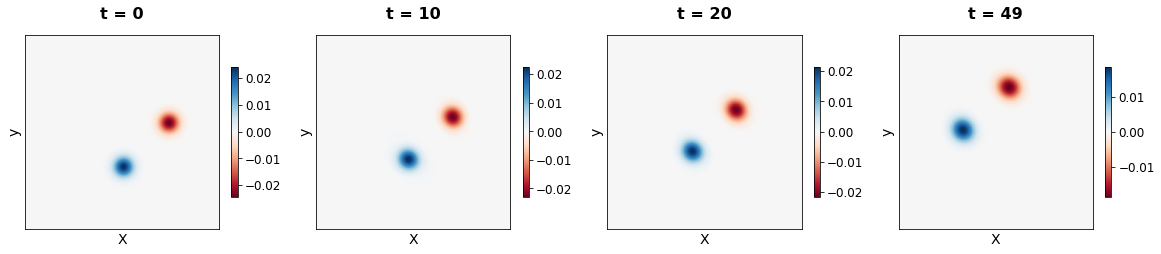

In [29]:
times = [0, 10, 20, 49]
data = data_file[17]
plot_vort(data, times)

###**Data Preparation**

The training dataset will consist of 100 samples of a high-fidelity numerical simulation each with 50 evenly sampled snapshots (in time). Each simulation represents velocity (in x and y directions) and pressure for the turbulent flow model over a region of grid size 256x256. These values can be used to generate a vorticity field for the model. Thus, there is a total number of 256 * 256 = 65,536 variables per time step and a total of 50 * 100 = 5,000 samples. Dimensionality reduction of this high dimensional space is then performed using Principal Component Analysis (PCA) in order to work with a relatively low dimension space.

In [ ]:
X_train = curl(data_file[:, :, :, :, 0], data_file[:, :, :, :, 1])
del data_file

In [35]:
vars = data_file.shape[-1]  # Number of variables per grid. u, v and p. 
nr = data_file.shape[2]     # Number of rows of grid in each time step.
nc = data_file.shape[3]     # Number of columns of grid in each time step.
times = data_file.shape[0] * data_file[1]
X_train3d = data_file.reshape(-1, nr, nc, vars )
print(X_train3d.shape)

(5000, 256, 256, 3)


In [1]:
data = X_train3d[0]
fig, ax = plt.subplots(1, 3, figsize=[20,16])
parameters = ['Velocity', 'Viscosity', 'Pressure']
for j in range(len(parameters)):
  img = data[:, :, j]
  ax[j].imshow(img)
  ax[j].set_title(parameters[j], fontsize=16, fontweight='bold', 
                        ha='right')
plt.show()

NameError: ignored

In [36]:
X_train2d = X_train3d.reshape(-1, nr*nc*vars)
print(X_train2d.shape)

(5000, 196608)
